# Import Libraries

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import vstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# Loading Datasets

In [178]:

data1 = pd.read_excel("Legal_Sentences_For_Training_With_BERT_With_Label.xlsx")
data2 = pd.read_excel("Testing_Set_Legal_Sentences.xlsx")


In [179]:
data1.head()

,ID,Phrase,Sentiment,Label
0,1,Getting nowhere with surplusage,-1,0
1,2,But the Court nowhere suggested that it would ...,-1,0
2,3,Petitioners objection to shaving his beard cla...,-1,0
3,4,That result clashes with everything else,-1,0
4,5,the tolerable duration of police inquiries in ...,0,1


In [180]:
data2.head()

,ID,sentence,label
0,1,has done nothing to satisfy the probable-cause...,0
1,2,"Addressing that question here , the CCA referr...",1
2,3,standards and procedures,1
3,4,has no comprehension of why he has been single...,0
4,5,"an expert , Dr. Woods , who offered the opinio...",2


# Data Exploration and Preprocessing

In [181]:
# Check for missing values
print(data1.isnull().sum())
print(data2.isnull().sum())

ID           0
Phrase       0
Sentiment    0
Label        0
dtype: int64
ID          0
sentence    0
label       0
dtype: int64


In [182]:
data1['Label'].value_counts() # checking the distributions of labels in data1

0    282
2    172
1    122
Name: Label, dtype: int64

In [183]:
data2['label'].value_counts() # checking the distributions of labels in data2

0    211
1    168
2    121
Name: label, dtype: int64

In [184]:
data1.drop('Sentiment', axis=1, inplace=True)

In [185]:
data1.head()

,ID,Phrase,Label
0,1,Getting nowhere with surplusage,0
1,2,But the Court nowhere suggested that it would ...,0
2,3,Petitioners objection to shaving his beard cla...,0
3,4,That result clashes with everything else,0
4,5,the tolerable duration of police inquiries in ...,1


In [186]:
data2.head()

,ID,sentence,label
0,1,has done nothing to satisfy the probable-cause...,0
1,2,"Addressing that question here , the CCA referr...",1
2,3,standards and procedures,1
3,4,has no comprehension of why he has been single...,0
4,5,"an expert , Dr. Woods , who offered the opinio...",2


In [187]:
data1.shape

(576, 3)

In [188]:
data2.shape

(500, 3)

In [189]:
# Preprocess the text data
data1['Phrase'] = data1['Phrase'].str.lower().str.replace('[^\w\s]', '')
data2['sentence'] = data2['sentence'].str.lower().str.replace('[^\w\s]', '')

# Semantic Analysis

In [190]:
# Using TF-IDF for keyword extraction on training data (data1)
vectorizer_tfidf = TfidfVectorizer(max_df=0.85, stop_words='english', max_features=10)
tfidf = vectorizer_tfidf.fit_transform(data1['Phrase'])

# Displaying top 10 keywords
print("Top 10 keywords:", vectorizer_tfidf.get_feature_names_out())


Top 10 keywords: ['case' 'conduct' 'court' 'courts' 'district' 'evidence' 'law' 'offense'
 'state' 'trial']


# Sentiment Analysis

In [191]:
def label_sentiment(value):
    if value == 0:
        return "negative"
    elif value == 1:
        return "neutral"
    else:
        return "positive"

data1['Label'] = data1['Label'].apply(label_sentiment)
data2['label'] = data2['label'].apply(label_sentiment)


In [192]:
# Define training and test sets
X_train = data1['Phrase']
y_train = data1['Label']
# splitting data2 into validation and testing dataset
X_val, X_test, y_val, y_test = train_test_split(data2['sentence'], data2['label'], test_size=0.5, random_state=42)


In [193]:
print(y_test.unique())


['negative' 'positive' 'neutral']


In [194]:
print(y_train.unique())


['negative' 'neutral' 'positive']


In [195]:
print(y_val.unique())

['neutral' 'positive' 'negative']


# Model Building 

In [196]:
# Vectorizing the phrases using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)
X_val_vec = tfidf_vectorizer.transform(X_val)

# Initialize the classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train_vec, y_train)


RandomForestClassifier()

# Evaluate on the validation set Before GridSearch

Performance metrics on validation set (before GridSearchCV):
Accuracy: 0.47
Precision: 0.53
Recall: 0.47
F1 Score: 0.37
Test Report:
               precision    recall  f1-score   support

    negative       0.45      0.94      0.61       105
     neutral       0.50      0.04      0.07        76
    positive       0.68      0.22      0.33        69

    accuracy                           0.47       250
   macro avg       0.54      0.40      0.34       250
weighted avg       0.53      0.47      0.37       250



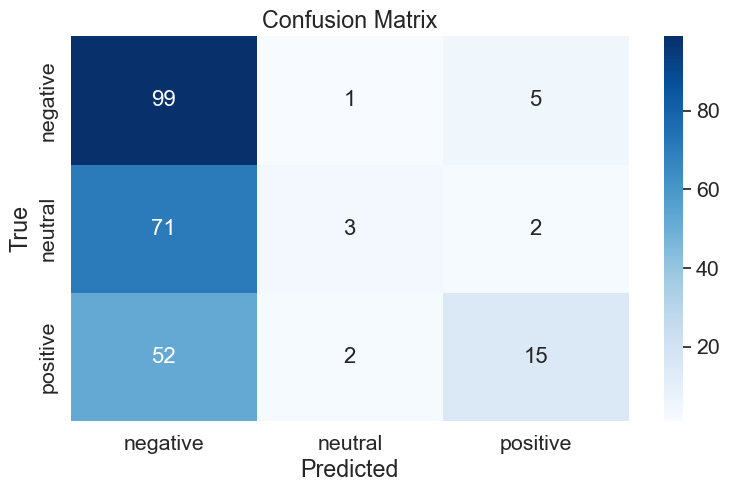

In [197]:
y_pred_val = rf_classifier.predict(X_val_vec)

print("Performance metrics on validation set (before GridSearchCV):")

# Calculating metrics
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='weighted')
recall = recall_score(y_val, y_pred_val, average='weighted')
f1 = f1_score(y_val, y_pred_val, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Displaying classification report for test set
print("Test Report:\n", classification_report(y_val, y_pred_val))

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_val, labels=["negative", "neutral", "positive"])

# Plot the confusion matrix
plt.figure(figsize=(9,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", 
            xticklabels=["negative", "neutral", "positive"], 
            yticklabels=["negative", "neutral", "positive"])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Hyperparameter tuning using GridSearchCV


In [205]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           cv=10, n_jobs=-1, verbose=0, scoring='accuracy')

# Combine training and validation sets for GridSearchCV
X_train_val_combined = vstack([X_train_vec, X_val_vec])
y_train_val_combined = pd.concat([y_train, y_val], axis=0)

grid_search.fit(X_train_val_combined, y_train_val_combined)

print("Best Parameters from Grid Search:", grid_search.best_params_)

Best Parameters from Grid Search: {'bootstrap': True, 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [206]:

# Print the best parameters from the grid search
print("Best Parameters from Grid Search:", grid_search.best_params_)

# Use the best model to predict on the test set
best_rf = grid_search.best_estimator_

Best Parameters from Grid Search: {'bootstrap': True, 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


#  Evaluate the best model obtained through HyperParameter Tuning on the test set


Performance metrics for Random Forest with Grid Search:
Accuracy: 0.44
Precision: 0.64
Recall: 0.44
F1 Score: 0.30
Test Report:
               precision    recall  f1-score   support

    negative       0.44      0.97      0.60       106
     neutral       1.00      0.01      0.02        92
    positive       0.43      0.12      0.18        52

    accuracy                           0.44       250
   macro avg       0.62      0.37      0.27       250
weighted avg       0.64      0.44      0.30       250



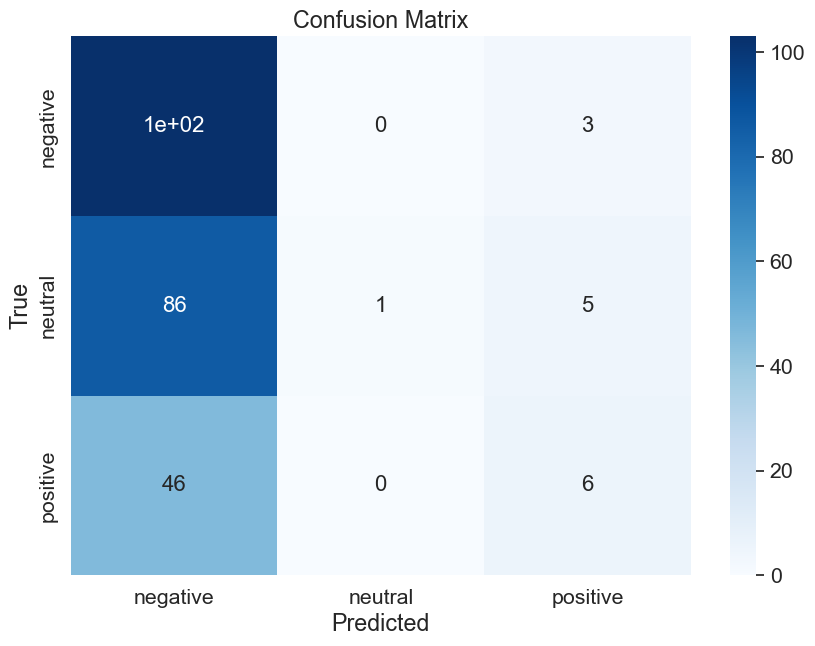

In [208]:
y_pred_best_rf = best_rf.predict(X_test_vec)

# Evaluate the classifier
print("Performance metrics for Random Forest with Grid Search:")

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_best_rf)
precision = precision_score(y_test, y_pred_best_rf, average='weighted')
recall = recall_score(y_test, y_pred_best_rf, average='weighted')
f1 = f1_score(y_test, y_pred_best_rf, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Displaying classification report for test set
print("Test Report:\n", classification_report(y_test, y_pred_best_rf))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_best_rf, labels=["negative", "neutral", "positive"])

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", 
            xticklabels=["negative", "neutral", "positive"], 
            yticklabels=["negative", "neutral", "positive"])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Interpretation of Results


Before hyperparameter tuning, the model exhibited an accuracy of 0.47 on the validation set. The precision, recall, and F1-score were 0.53, 0.47, and 0.37 respectively. The 'negative' class had a high recall of 0.94, indicating that the model was proficient at identifying the negative samples. However, the model struggled with the 'neutral' and 'positive' classes, with particularly low recall and F1-scores for the 'neutral' class.

After hyperparameter tuning using GridSearchCV, the overall accuracy slightly decreased to 0.44. Interestingly, the precision for the 'neutral' class surged to 1.00, but its recall plummeted to 0.01, meaning the model almost never correctly identified 'neutral' samples despite being highly confident when it did. The 'negative' class maintained a high recall of 0.97. The overall weighted precision increased after tuning, but the recall and F1-score dropped.

In summary, hyperparameter tuning did not significantly improve the model's performance on the test set. While the precision for the 'neutral' class increased, the model's ability to identify 'neutral' samples decreased. The model, both before and after tuning, is particularly good at identifying the 'negative' class but struggles with 'neutral' and 'positive' classifications. Further investigations and potentially other techniques might be needed to enhance the model's performance across all classes.

